In [60]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from seaborn_qqplot import pplot
import statsmodels.api as sm
import pingouin as pg

from scipy.stats import trim_mean

default_font_size = 18
plt.rcParams.update({'font.size': default_font_size})

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [61]:
population_size = 45
num_faces = 32

# Useful Function

In [62]:
def extract_population_response(df, model_idx, col):
    """
    df: the dataframe to extract the responses from
    model_idx: which model we want
    col: the column index of responses we want

    The dataframe was made in the following format
                feat 1 | feat 2 | feat 3 ...
    ------------------------------------------
            |      
    model 0 |
            |
    ------------------------------------------
            |
    model 1 |
            |
    ...
    """
    series = df[col] #the 
    return series.iloc[model_idx*num_faces:(model_idx+1)*num_faces]

In [63]:
def create_mean_df(df, proportiontocut=0.2):
    new_df = pd.DataFrame(0, index=np.arange(population_size), columns=list(df.columns)+["model_idx"])

    for model_idx in range(population_size):
        for col_idx, col in enumerate(df.columns):
            series = extract_population_response(df, model_idx, col)
            ave_response = trim_mean(series, proportiontocut=proportiontocut)
            new_df.at[model_idx, col] = ave_response
            new_df.at[model_idx, 'model_idx'] = model_idx
    return new_df

In [64]:
def pairwise_anova(df, cols, dv, within, subject, correction, detailed):
    results = []
    
    for i in range(len(cols)-1):
        for j in range(i+1, len(cols)):
            temp = df[(df[within]==cols[i]) | (df[within]==cols[j])]
            
            res = pg.rm_anova(data=temp, dv=dv, within=within, subject=subject, 
                  correction=correction, detailed=detailed)

            results.append((cols[i], cols[j], res))
    return results

In [65]:
def extract_outliers(series):
    #given a pd.Series, extract the indices of the outliers
    # outliers are points x such that:
    # x > Q3 + 1.5*IQR
    # x < Q1 - 1.5*IQR
    # IQR = Q3-Q1
    # Q1, 25th percentile
    # Q3, 75th percentile
    Q1 = series.quantile(q=0.25, interpolation='linear')
    Q3 = series.quantile(q=0.75, interpolation='linear')
    IQR = Q3 - Q1
    return series.index[(series > Q3 + 1.5*IQR) | (series < Q1 - 1.5*IQR)]

# Load Data

In [74]:
df_feature_combination = pd.read_csv("feature_combinations_june_14_no_reflections.csv", index_col=0)

In [92]:
(df_feature_combination*300/17).round(2)[temp_cols].head()

,1 Eye,2 Eyes,"1 Eye, Nose","1 Eye, Mouth","2 Eyes, Nose","1 Eye, Nose, Mouth","2 Eyes, Mouth",Full Face
0,270.09,221.03,247.76,240.97,211.59,216.35,202.85,185.91
1,267.53,231.44,250.15,230.38,219.00,221.82,201.35,195.71
2,269.91,227.29,243.00,217.68,222.79,199.15,209.74,203.82
3,274.15,223.24,230.82,227.12,211.59,228.35,218.38,194.74
4,278.82,233.21,243.71,232.59,211.68,227.65,206.12,192.09


In [76]:
df_mean_responses = create_mean_df(df_feature_combination, proportiontocut=0)
df_mean_responses.round(2).head()

,1 Eye,2 Eyes,"1 Eye, Nose","1 Eye, Mouth","2 Eyes, Nose","1 Eye, Nose, Mouth",Full Face,"2 Eyes, Mouth",model_idx
0,15.02,12.82,13.90,13.41,12.00,12.51,10.95,11.64,0
1,15.28,12.92,14.00,13.53,11.99,12.52,10.91,11.66,1
2,15.16,12.93,14.10,13.74,12.15,12.87,11.24,11.89,2
3,16.96,14.32,15.80,14.57,13.48,13.71,11.98,12.60,3
4,14.80,13.02,13.76,13.28,12.21,12.44,11.18,11.83,4


## Plotting

In [91]:
temp_cols = ['1 Eye', '2 Eyes', '1 Eye, Nose', '1 Eye, Mouth', '2 Eyes, Nose',
       '1 Eye, Nose, Mouth', '2 Eyes, Mouth', 'Full Face']

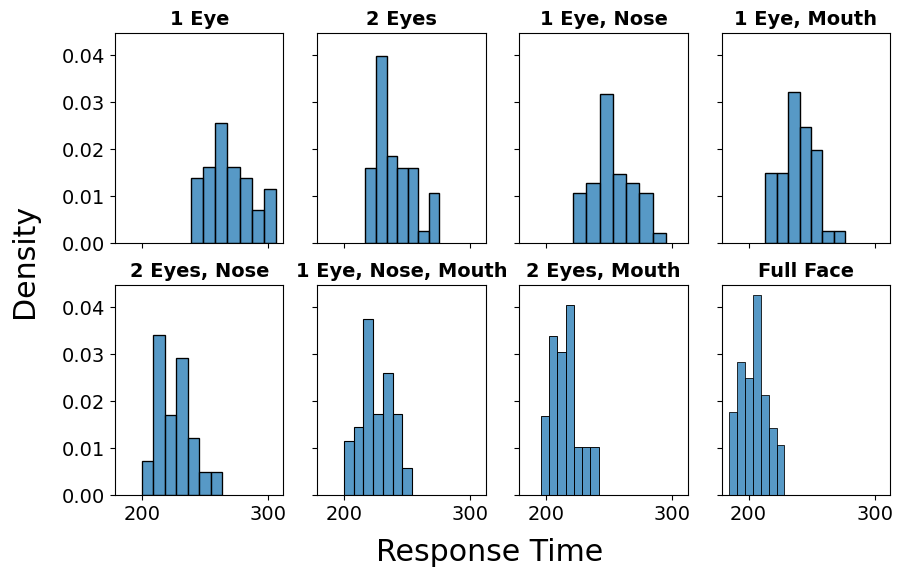

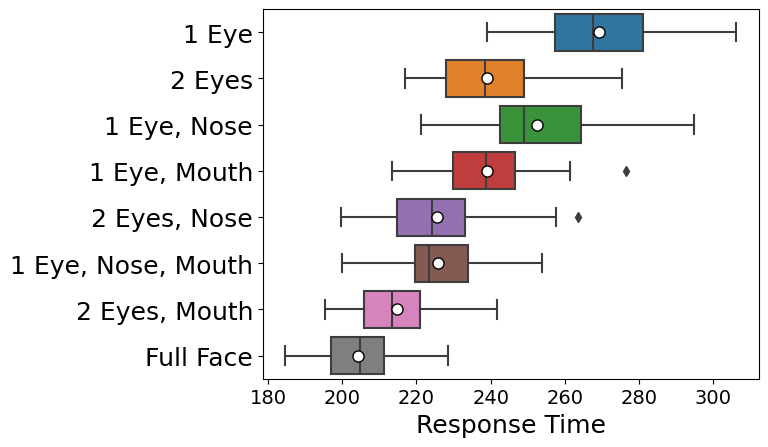

In [84]:
include_outliers = True

if include_outliers: #include everything
    df_subset = df_mean_responses[temp_cols]
else:
    df_subset = df_mean_responses[temp_cols].copy()
    for col in df_subset.columns:
        indices = extract_outliers(df_subset[col])
        df_subset[col][indices] = np.nan

fig, axes = plt.subplots(2, 4, sharex=True, sharey=True, figsize=(10, 6))

for i in range(len(df_subset.columns)):
    sns.histplot(df_subset*300/17, x=df_subset.columns[i], stat="density", ax=axes[i//4, i%4]).set(ylabel="")
    axes[i//4, i%4].set_title(df_subset.columns[i], fontsize=14, weight='bold')
    axes[i//4, i%4].set_xlabel("")
#axes[-1, 0].set_xlabel("Response Time", fontsize=default_font_size)
#axes[-1, 1].set_xlabel("Response Time", fontsize=default_font_size)
fig.supylabel("Density", x=0.02)
fig.supxlabel("Response Time", y=-0.01)
for ax in axes.flatten():
    ax.tick_params(axis='x', labelsize=14)
    ax.tick_params(axis='y', labelsize=14)
plt.savefig("comb_hist.svg", format="svg")
plt.show()

#boxplot
fig, ax = plt.subplots()
sns.boxplot(df_mean_responses[temp_cols]*300/17, orient="h", showfliers=include_outliers,
            showmeans=True,
            meanprops={'marker':'o',
                       'markerfacecolor':'white', 
                       'markeredgecolor':'black',
                       'markersize':'8'})
#ax.tick_params(axis='x', labelrotation=30)
#plt.title(f"{args.test_convergence_norm} Convergence", fontsize=14, weight="bold")
plt.xlabel("Response Time", fontsize=default_font_size)
ax.tick_params(axis='x', labelsize=14)
#ax.tick_params(axis='y', labelsize=14)
plt.savefig("comb_boxplot.svg", format="svg")
plt.show()

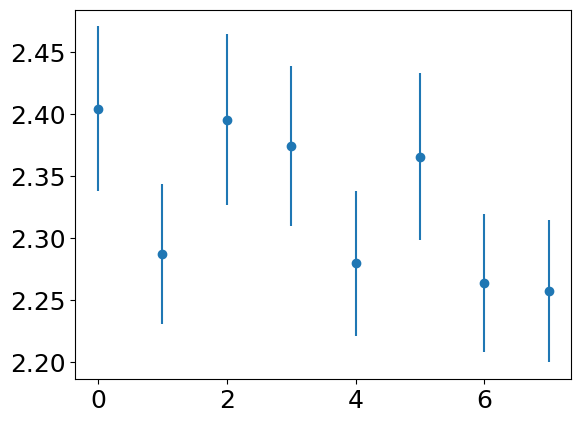

In [55]:
plt.figure()

plt.errorbar(range(8), df_mean_responses[temp_cols].mean().to_numpy(), yerr=df_mean_responses[temp_cols].std().to_numpy(), ls="", marker="o")

plt.show()

In [12]:
for col in temp_cols:
    print(f"{col} & {df_mean_responses[col].mean():.2f} & {df_mean_responses[col].std():.2f} \\\\")

1 Eye & 2.40 & 0.07 \\
2 Eyes & 2.29 & 0.06 \\
1 Eye, Nose & 2.40 & 0.07 \\
1 Eye, Mouth & 2.37 & 0.06 \\
2 Eyes, Nose & 2.28 & 0.06 \\
1 Eye, Nose, Mouth & 2.37 & 0.07 \\
2 Eyes, Mouth & 2.26 & 0.06 \\
Full Face & 2.26 & 0.06 \\


In [13]:
from scipy.stats import skewtest
skewtest(df_mean_responses["2 Eyes"].to_numpy())

SkewtestResult(statistic=1.027441024593799, pvalue=0.30421284225222434)

## Histograms

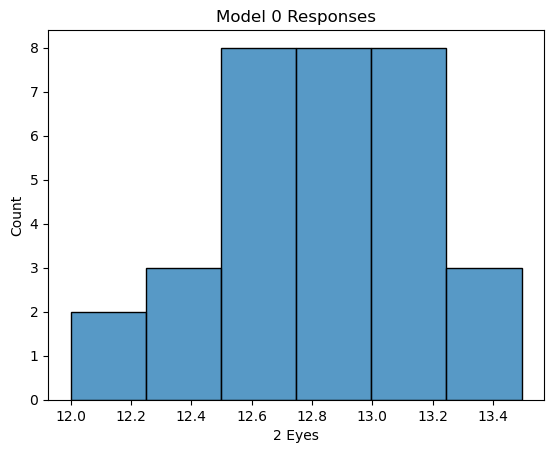

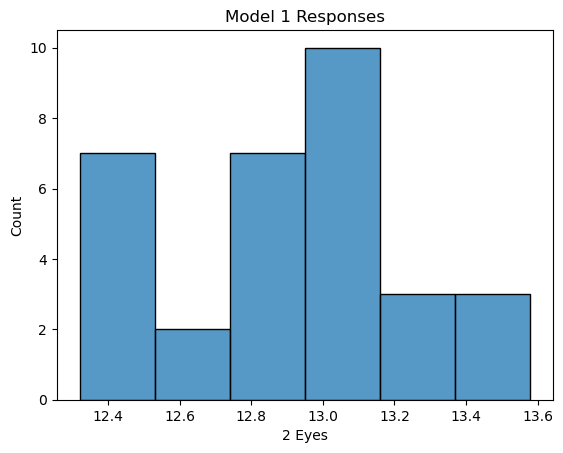

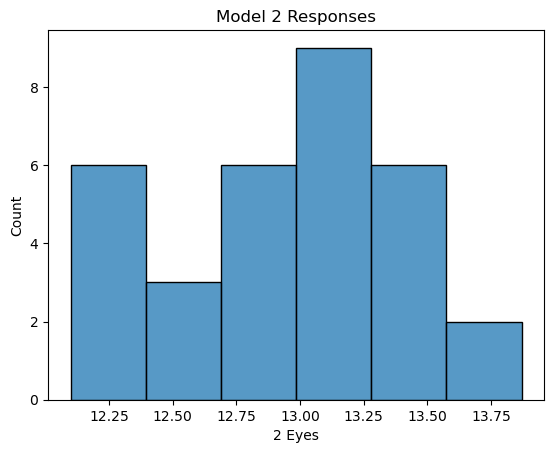

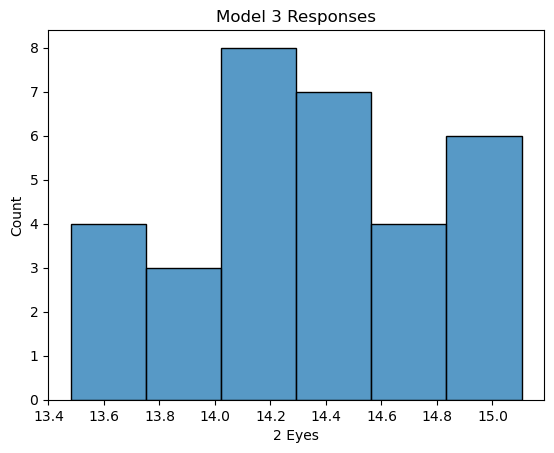

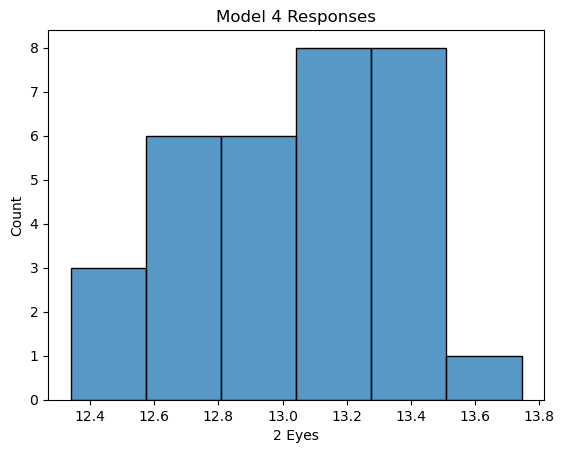

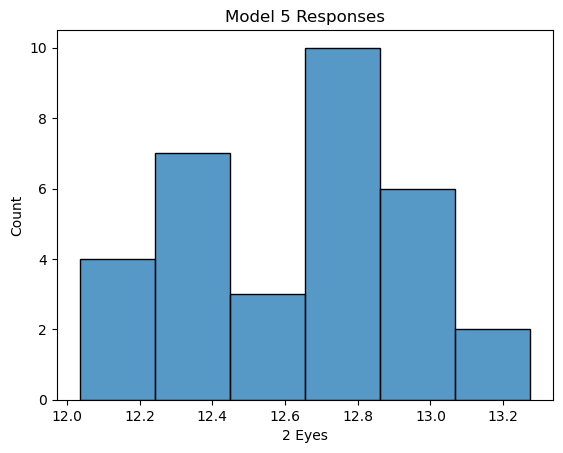

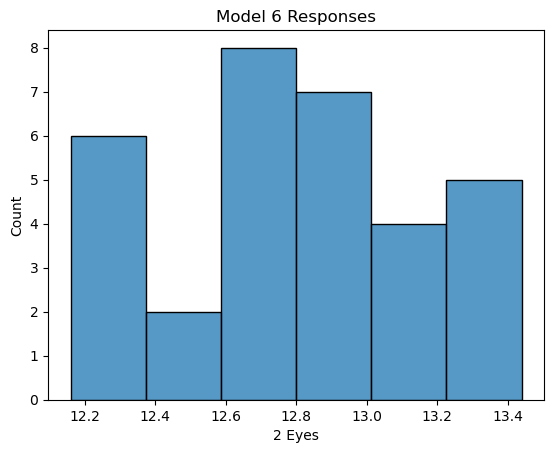

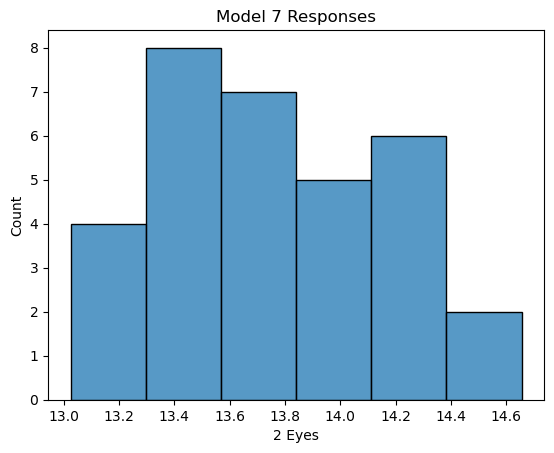

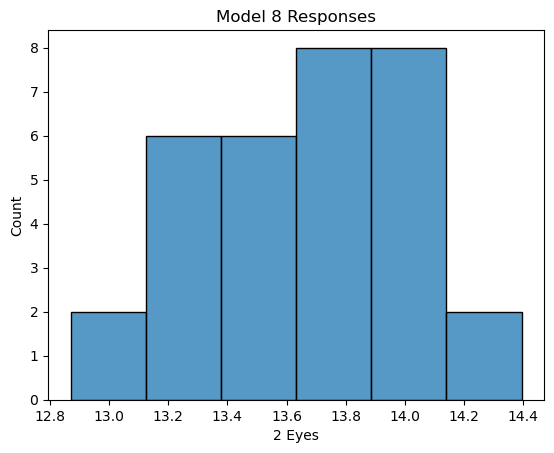

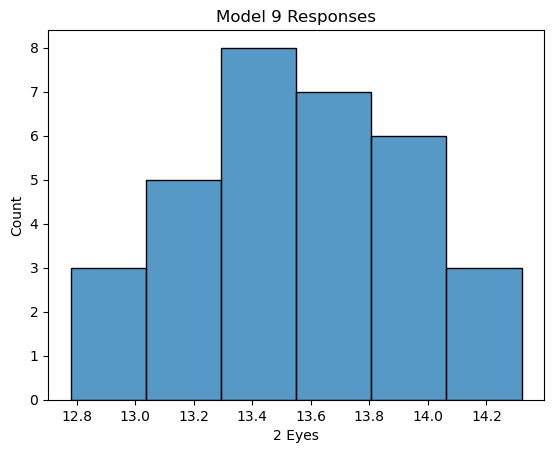

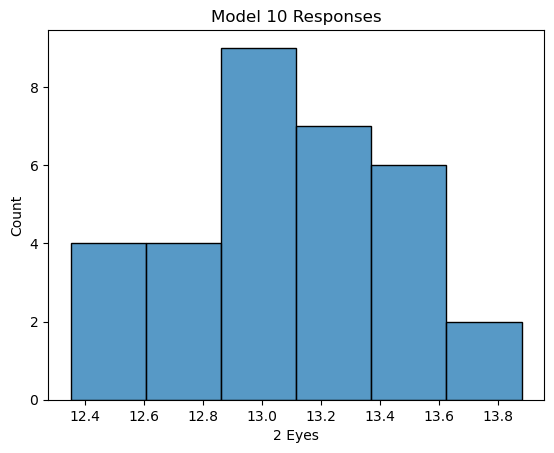

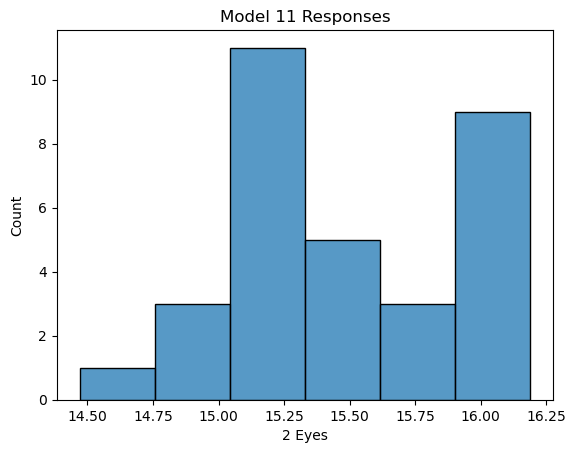

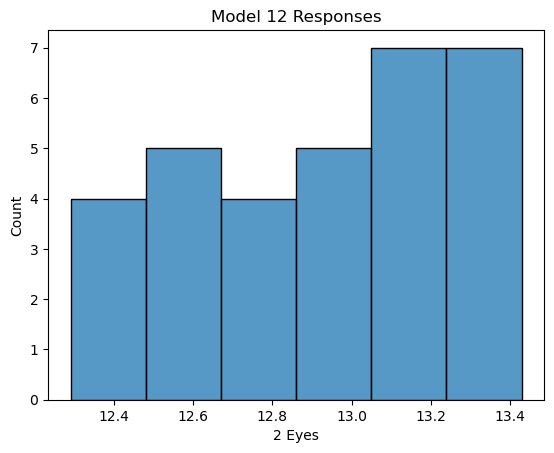

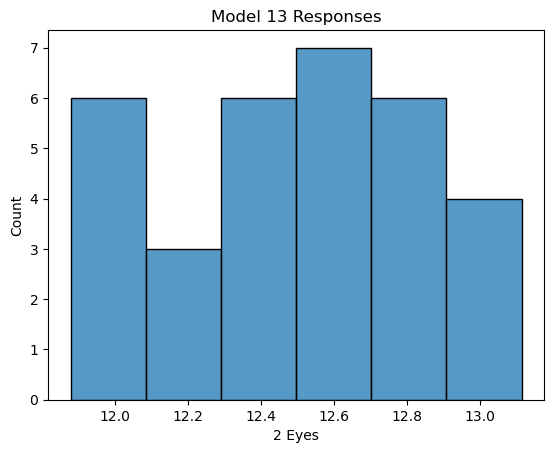

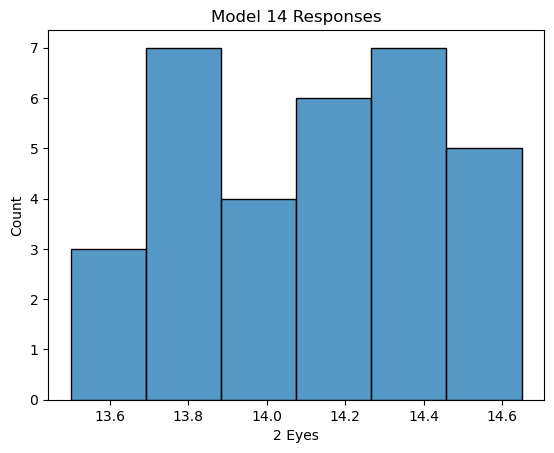

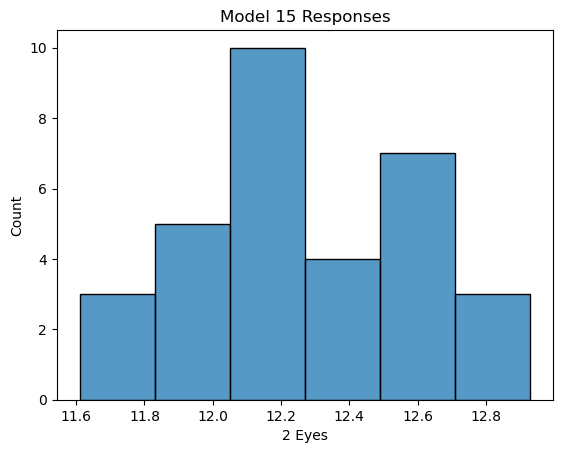

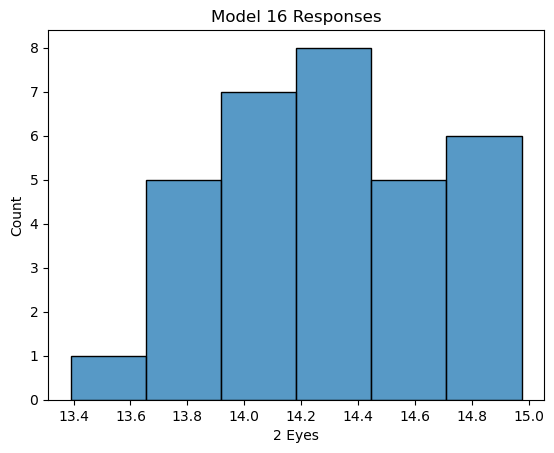

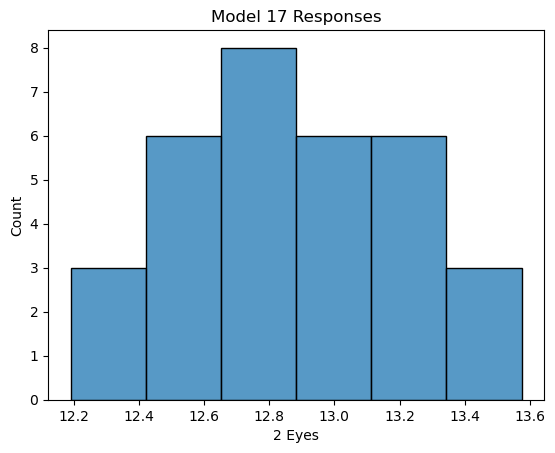

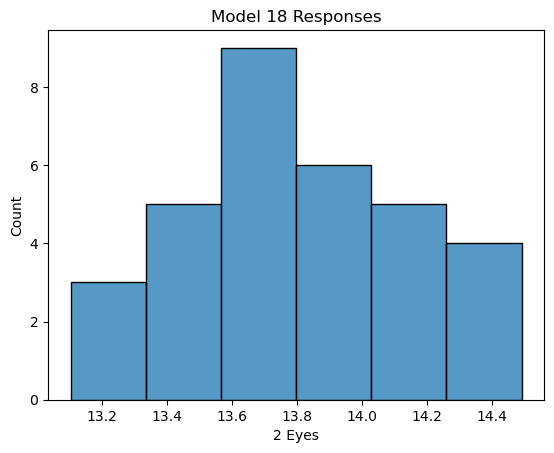

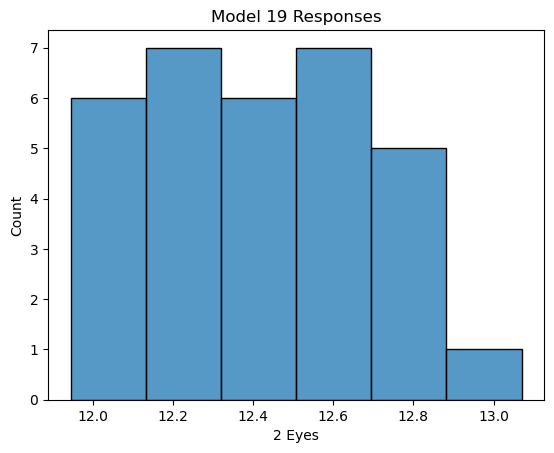

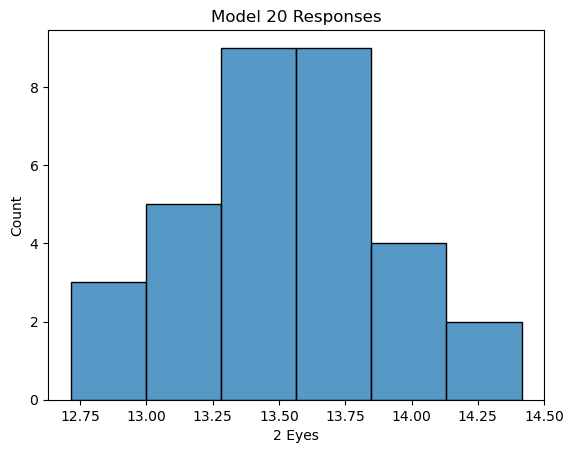

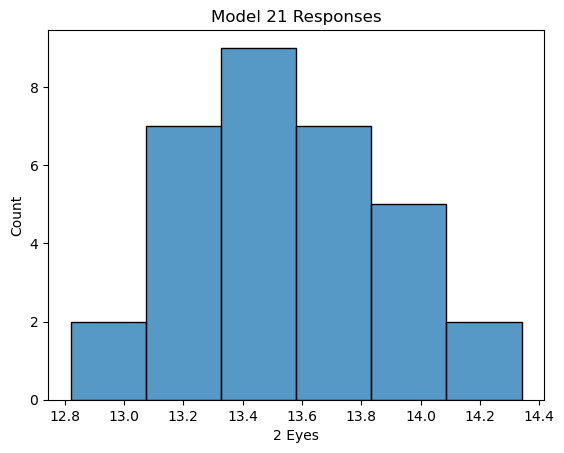

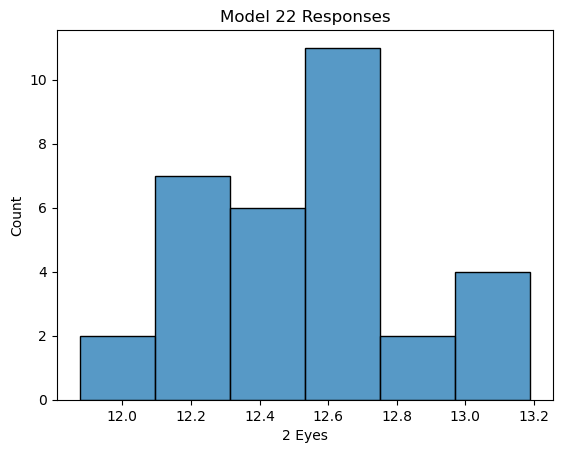

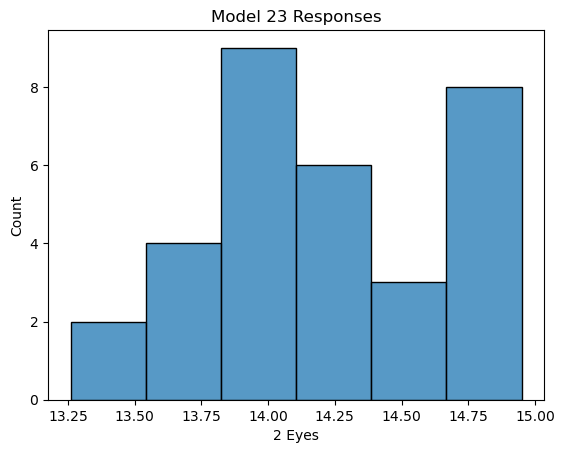

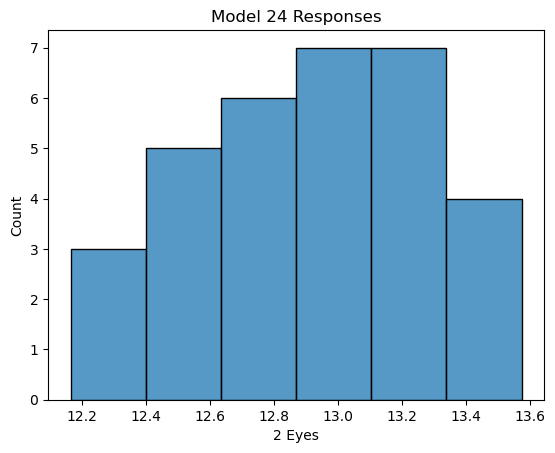

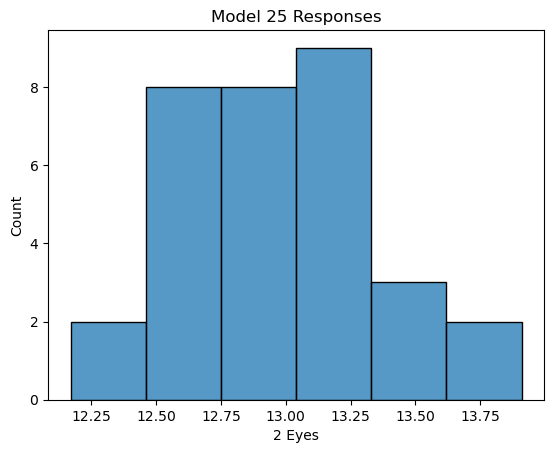

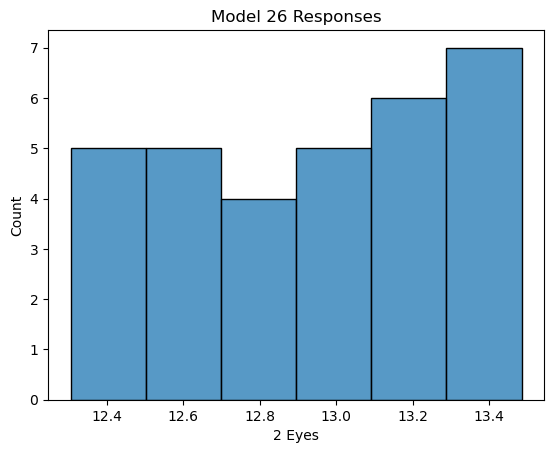

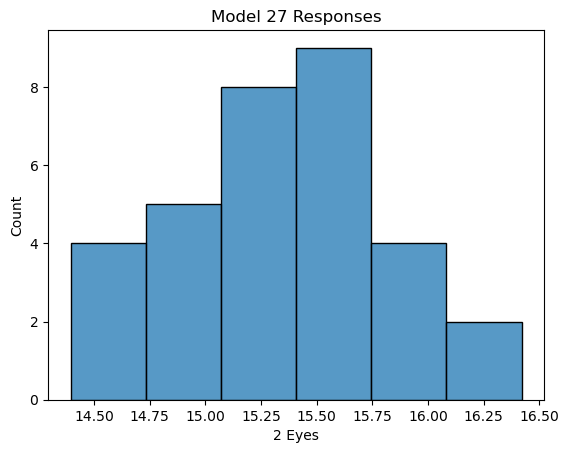

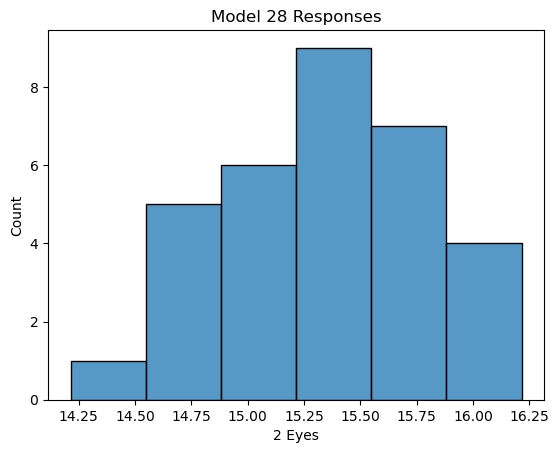

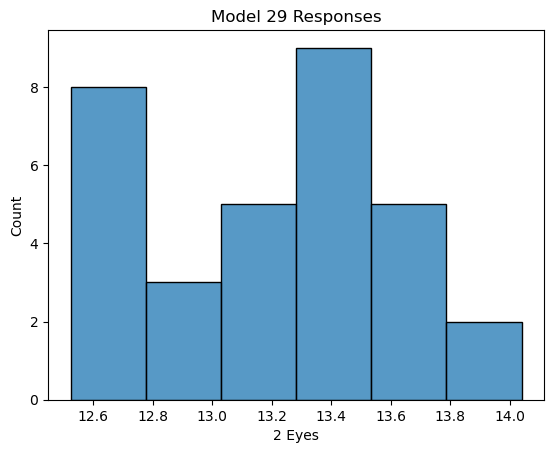

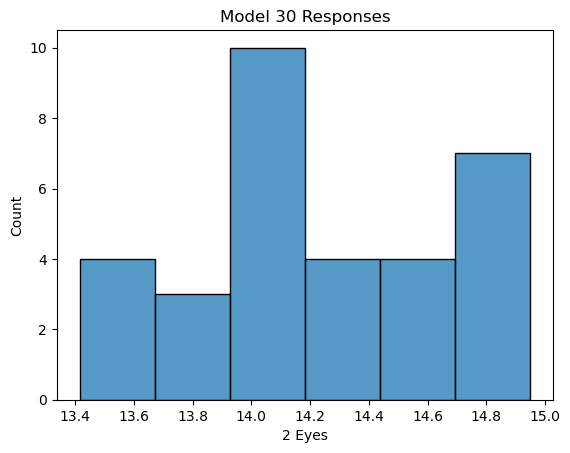

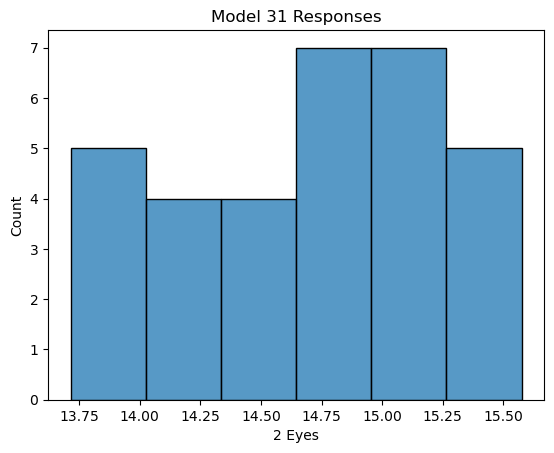

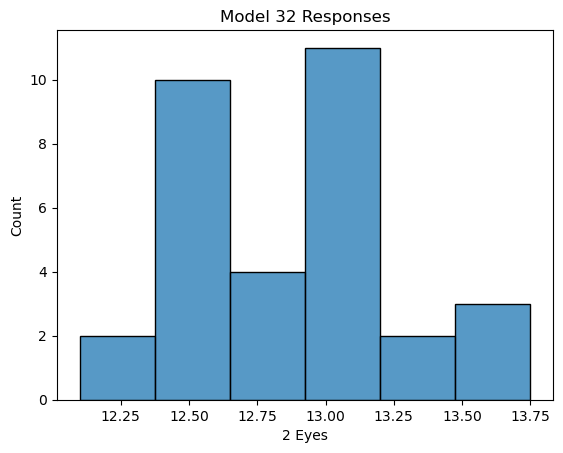

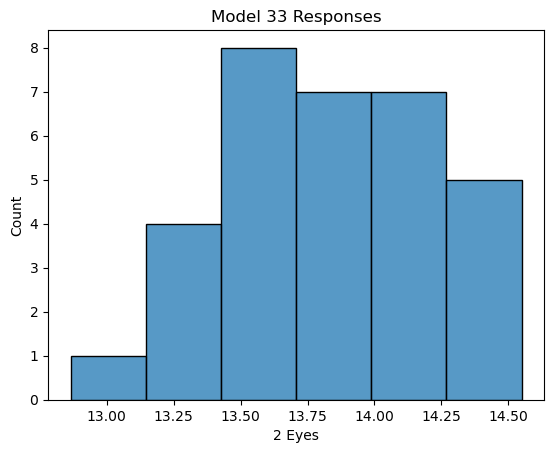

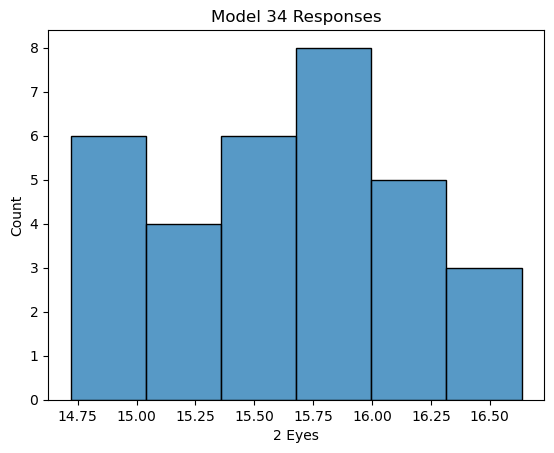

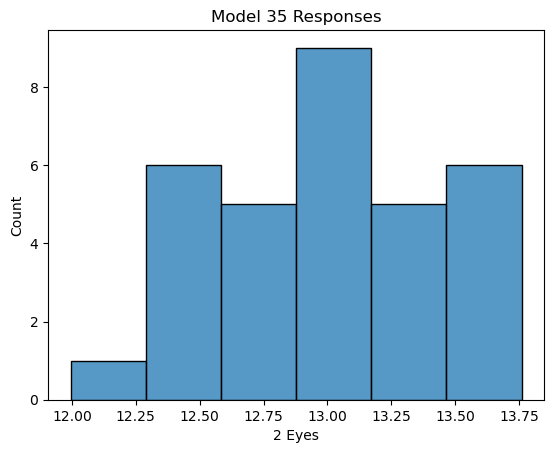

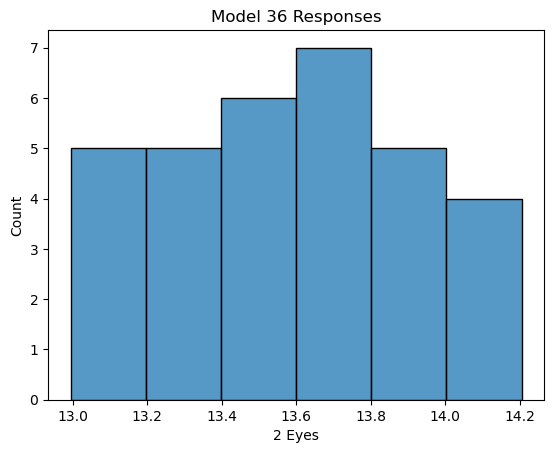

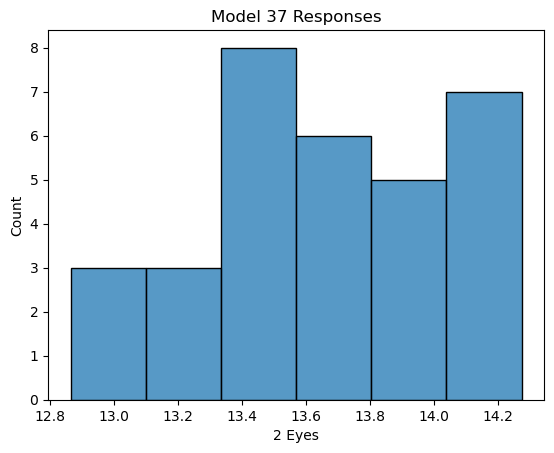

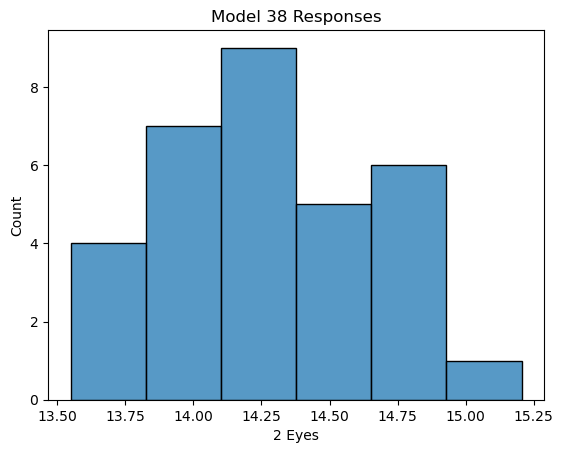

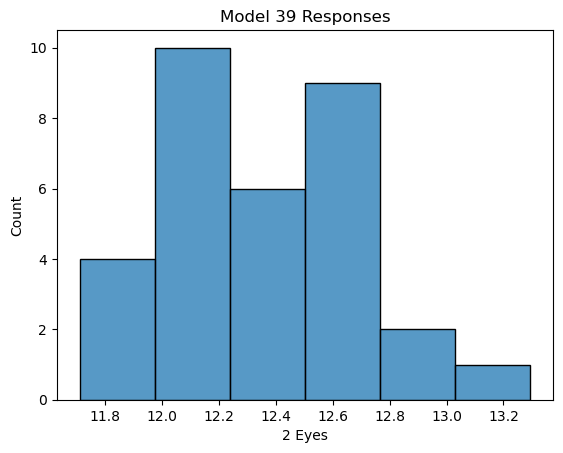

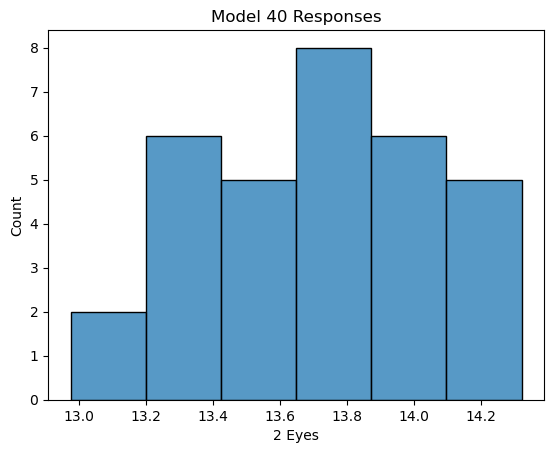

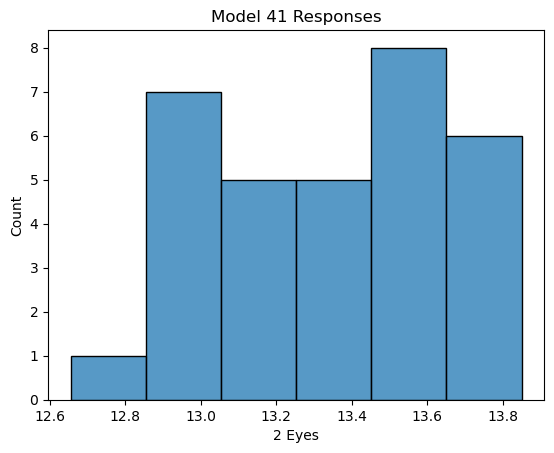

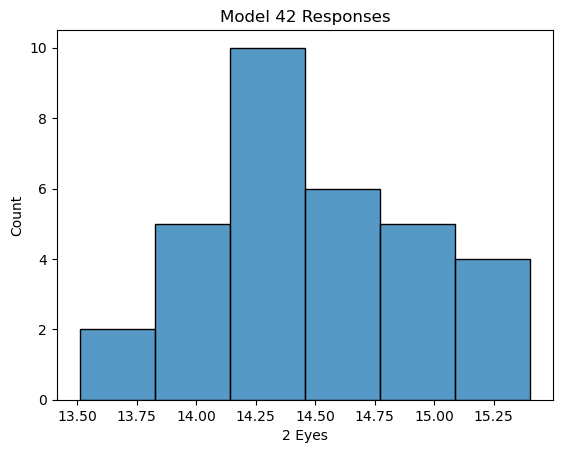

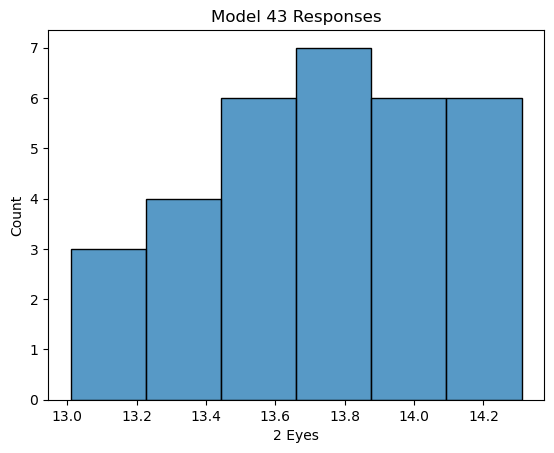

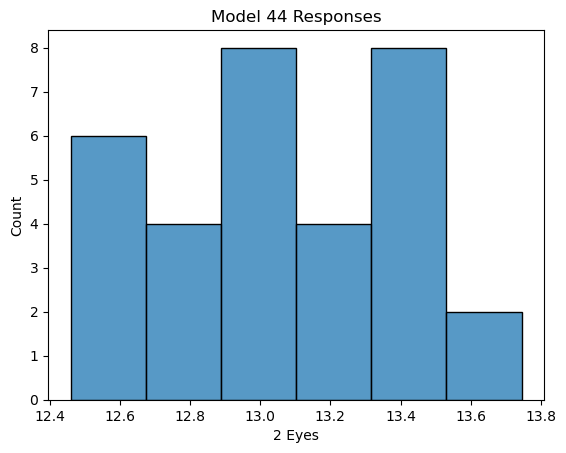

In [9]:
for i in range(population_size):
    series = extract_population_response(df_feature_combination, i, "2 Eyes")
    plt.figure()
    plt.title(f"Model {i} Responses")
    sns.histplot(series)
    plt.show()

# ANOVA

In [38]:
df_anova = pd.melt(df_mean_responses.reset_index(), id_vars=['model_idx'], value_vars=df_feature_combination.columns)
df_anova.columns = ["model_idx", "feature_combination", "mean"]
df_anova.head()

,model_idx,feature_combination,mean
0,0,1 Eye,2.325000
1,1,1 Eye,2.314375
2,2,1 Eye,2.427812
3,3,1 Eye,2.426094
4,4,1 Eye,2.471875


In [39]:
res = pg.rm_anova(data=df_anova, dv='mean', within='feature_combination', subject='model_idx', 
                  correction=True, detailed=False)
res

/home/wpugsley/.local/lib/python3.11/site-packages/pingouin/distribution.py:1004: RuntimeWarning: divide by zero encountered in double_scalars
  W = np.prod(eig) / (eig.sum() / d) ** d


,Source,ddof1,ddof2,F,p-unc,p-GG-corr,ng2,eps,sphericity,W-spher,p-spher
0,feature_combination,7,308,2509.782319,2.119008e-267,2.809922e-83,0.473452,0.304384,True,inf,1.0


## Check Assumptions for ANOVA

In [40]:
pg.sphericity(data=df_anova, dv='mean', within='feature_combination', subject='model_idx')

/home/wpugsley/.local/lib/python3.11/site-packages/pingouin/distribution.py:1004: RuntimeWarning: divide by zero encountered in double_scalars
  W = np.prod(eig) / (eig.sum() / d) ** d


SpherResults(spher=True, W=inf, chi2=-inf, dof=27, pval=1.0)

In [41]:
#pg.normality(data=df_anova, dv='mean', group='feature_combination', alpha=0.05/8)
pg.normality(data=df_anova, dv='mean', group='feature_combination', alpha=0.05)

,W,pval,normal
feature_combination,,,
1 Eye,0.977094,0.506859,True
2 Eyes,0.971927,0.339480,True
"1 Eye, Nose",0.974952,0.431632,True
"1 Eye, Mouth",0.968146,0.247726,True
"2 Eyes, Nose",0.971695,0.333122,True
"1 Eye, Nose, Mouth",0.970481,0.301419,True
Full Face,0.965063,0.190115,True
"2 Eyes, Mouth",0.961044,0.133877,True


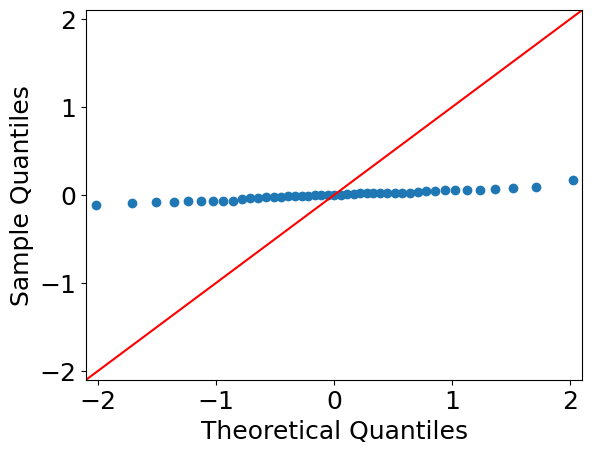

In [18]:
sm.qqplot(df_mean_responses["2 Eyes"]-df_mean_responses["2 Eyes"].mean(), line='45')
plt.show()

## Pairwise t-Tests

In [59]:
pg.ttest(df_mean_responses["Full Face"], df_mean_responses["2 Eyes, Mouth"], paired=True)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-7.545765,44,two-sided,1.827045e-09,"[-0.01, -0.0]",0.114262,6.378e+06,0.116488


In [56]:
post_hocs = pg.pairwise_tests(data=df_anova, dv='mean', within='feature_combination', subject='model_idx', 
                              padjust='bonf', alternative='two-sided')
post_hocs[post_hocs.B=="Full Face"]
post_hocs

,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,hedges
0,feature_combination,1 Eye,"1 Eye, Mouth",True,True,20.895524,44.0,two-sided,1.794360e-24,5.024207e-23,bonf,1.951e+21,0.457485
1,feature_combination,1 Eye,"1 Eye, Nose",True,True,8.006296,44.0,two-sided,3.950835e-10,1.106234e-08,bonf,2.736e+07,0.131127
2,feature_combination,1 Eye,"1 Eye, Nose, Mouth",True,True,24.056207,44.0,two-sided,5.953207e-27,1.666898e-25,bonf,5.053e+23,0.576800
3,feature_combination,1 Eye,2 Eyes,True,True,68.647296,44.0,two-sided,2.164751e-46,6.061304e-45,bonf,4.72e+42,1.889993
4,feature_combination,1 Eye,"2 Eyes, Mouth",True,True,59.889424,44.0,two-sided,8.247754e-44,2.309371e-42,bonf,1.422e+40,2.282116
5,feature_combination,1 Eye,"2 Eyes, Nose",True,True,80.164746,44.0,two-sided,2.481175e-49,6.947289e-48,bonf,3.522e+45,1.979671
6,feature_combination,1 Eye,Full Face,True,True,68.842210,44.0,two-sided,1.913008e-46,5.356422e-45,bonf,5.326e+42,2.354840
7,feature_combination,"1 Eye, Mouth","1 Eye, Nose",True,True,-10.666173,44.0,two-sided,8.805494e-14,2.465538e-12,bonf,8.598e+10,-0.315144
8,feature_combination,"1 Eye, Mouth","1 Eye, Nose, Mouth",True,True,8.045806,44.0,two-sided,3.467289e-10,9.708408e-09,bonf,3.099e+07,0.129517
9,feature_combination,"1 Eye, Mouth",2 Eyes,True,True,50.498800,44.0,two-sided,1.347236e-40,3.772260e-39,bonf,1.035e+37,1.423123


In [20]:
print(f"Treatment A & Treatment B & $p$-value & DOF & $T$\\\\")
print("\\hline")
for row in post_hocs.iterrows():
    row = row[1]
    print(f"{row['A']} & {row['B']} & ${row['p-corr']}$ & ${int(row['dof'])}$ & ${row['T']:.2f}$\\\\")

Treatment A & Treatment B & $p$-value & DOF & $T$\\
\hline
1 Eye & 1 Eye, Mouth & $5.024206995744171e-23$ & $44$ & $20.90$\\
1 Eye & 1 Eye, Nose & $1.1062337095887728e-08$ & $44$ & $8.01$\\
1 Eye & 1 Eye, Nose, Mouth & $1.6668980467036963e-25$ & $44$ & $24.06$\\
1 Eye & 2 Eyes & $6.061304126377696e-45$ & $44$ & $68.65$\\
1 Eye & 2 Eyes, Mouth & $2.309371186472099e-42$ & $44$ & $59.89$\\
1 Eye & 2 Eyes, Nose & $6.947288838616556e-48$ & $44$ & $80.16$\\
1 Eye & Full Face & $5.356421960719838e-45$ & $44$ & $68.84$\\
1 Eye, Mouth & 1 Eye, Nose & $2.46553837842018e-12$ & $44$ & $-10.67$\\
1 Eye, Mouth & 1 Eye, Nose, Mouth & $9.708407935267894e-09$ & $44$ & $8.05$\\
1 Eye, Mouth & 2 Eyes & $3.772259918820559e-39$ & $44$ & $50.50$\\
1 Eye, Mouth & 2 Eyes, Mouth & $1.2975666587602302e-45$ & $44$ & $71.12$\\
1 Eye, Mouth & 2 Eyes, Nose & $1.182764744742484e-40$ & $44$ & $54.70$\\
1 Eye, Mouth & Full Face & $2.768940350198442e-48$ & $44$ & $81.87$\\
1 Eye, Nose & 1 Eye, Nose, Mouth & $8.72453499

# 1 Parafoveal Feature

In [21]:
results = pairwise_anova(df_anova, ["2 Eyes", "1 Eye, Nose", "1 Eye, Mouth"], 
                         dv='mean', within='feature_combination', subject='model_idx', 
                         correction=True, detailed=True)

In [16]:
for result in results:
    print(f"{result[0]} and {result[1]} gives")
    try:
        print("\t", result[2]["p-GG-corr"][0])
    except:
        print("\t", result[2]["p-unc"][0])

2 Eyes and 1 Eye, Nose gives
	 4.0875247425878856e-14
2 Eyes and 1 Eye, Mouth gives
	 0.9990499062464758
1 Eye, Nose and 1 Eye, Mouth gives
	 4.5509892707023604e-14


# 2 Parafoveal Features

In [17]:
results = pairwise_anova(df_anova, ["2 Eyes, Nose", "1 Eye, Nose, Mouth", "2 Eyes, Mouth"], 
                         dv='mean', within='feature_combination', subject='model_idx', 
                         correction=True, detailed=True)

In [18]:
for result in results:
    print(f"{result[0]} and {result[1]} gives")
    try:
        print("\t", result[2]["p-GG-corr"][0])
    except:
        print("\t", result[2]["p-unc"][0])

2 Eyes, Nose and 1 Eye, Nose, Mouth gives
	 0.9069249623007876
2 Eyes, Nose and 2 Eyes, Mouth gives
	 2.604758831984089e-14
1 Eye, Nose, Mouth and 2 Eyes, Mouth gives
	 4.243699737864664e-15


# Parafoveal Feature Count

In [77]:
df_parafoveal = pd.DataFrame(0, index=np.arange(population_size), columns=["0 Parafoveal Features",
                                                                          "1 Parafoveal Features",
                                                                          "2 Parafoveal Features",
                                                                          "3 Parafoveal Features",
                                                                          "model_idx"])
for model_idx in range(population_size):
    df_parafoveal.at[model_idx, "0 Parafoveal Features"] = df_mean_responses["1 Eye"].iloc[model_idx]
    df_parafoveal.at[model_idx, "1 Parafoveal Features"] = df_mean_responses[["2 Eyes", "1 Eye, Nose", "1 Eye, Mouth"]].iloc[model_idx].mean()
    df_parafoveal.at[model_idx, "2 Parafoveal Features"] = df_mean_responses[["2 Eyes, Nose", "1 Eye, Nose, Mouth", "2 Eyes, Mouth"]].iloc[model_idx].mean()
    df_parafoveal.at[model_idx, "3 Parafoveal Features"] = df_mean_responses["Full Face"].iloc[model_idx]
    df_parafoveal.at[model_idx, "model_idx"] = model_idx

In [78]:
df_parafoveal = pd.DataFrame()

df_parafoveal["0 Parafoveal Features"] = df_mean_responses["1 Eye"]

new_df = pd.DataFrame()
new_df["1 Parafoveal Feature"] = pd.concat([df_mean_responses["2 Eyes"], df_mean_responses["1 Eye, Nose"], df_mean_responses["1 Eye, Mouth"]], 
                                        ignore_index=True)
df_parafoveal = pd.concat([df_parafoveal, new_df], axis=1)

new_df = pd.DataFrame()
new_df["2 Parafoveal Features"] = pd.concat([df_mean_responses["2 Eyes, Nose"], df_mean_responses["1 Eye, Nose, Mouth"], df_mean_responses["2 Eyes, Mouth"]], 
                                        ignore_index=True)
df_parafoveal = pd.concat([df_parafoveal, new_df], axis=1)

new_df = pd.DataFrame()
new_df["3 Parafoveal Features"] = df_mean_responses["Full Face"]
df_parafoveal = pd.concat([df_parafoveal, new_df], axis=1)

new_df = pd.DataFrame()
new_df["model_idx"] = pd.Series([i for i in range(3*population_size)])
df_parafoveal = pd.concat([df_parafoveal, new_df], axis=1)

df_parafoveal = df_parafoveal.replace([np.inf, -np.inf], np.nan)

In [79]:
df_parafoveal.head()

,0 Parafoveal Features,1 Parafoveal Feature,2 Parafoveal Features,3 Parafoveal Features,model_idx
0,15.022188,12.824687,11.995312,10.950937,0
1,15.276094,12.920937,11.990000,10.910000,1
2,15.157500,12.934375,12.153750,11.240937,2
3,16.957500,14.315156,13.484219,11.980937,3
4,14.797187,13.016250,12.213750,11.175469,4


## Plotting

In [86]:
temp_cols = ['0 Parafoveal Features', '1 Parafoveal Feature',
       '2 Parafoveal Features', '3 Parafoveal Features']

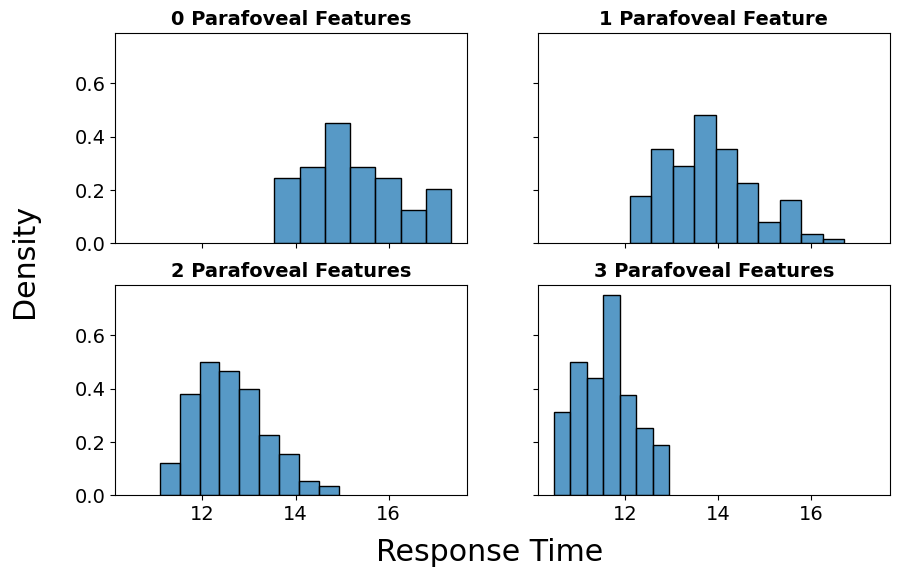

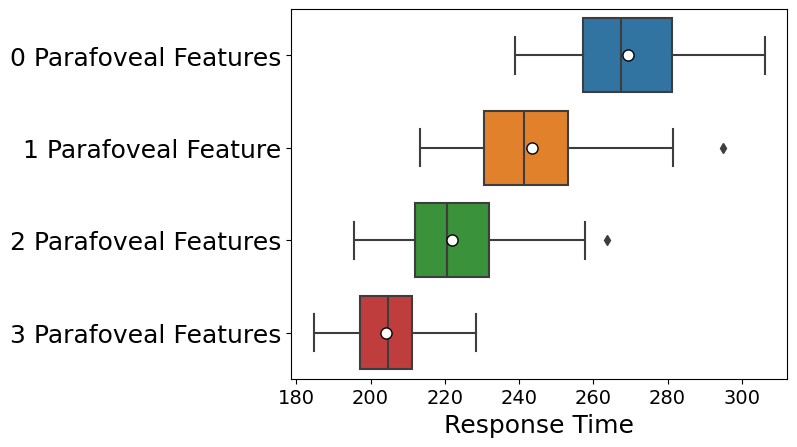

In [87]:
include_outliers = True

if include_outliers: #include everything
    df_subset = df_parafoveal[temp_cols]
else:
    df_subset = df_parafoveal[temp_cols].copy()
    for col in df_subset.columns:
        indices = extract_outliers(df_subset[col])
        df_subset[col][indices] = np.nan

fig, axes = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(10, 6))

sns.histplot(df_subset, x=df_subset.columns[0], stat="density", ax=axes[0, 0]).set(ylabel="")
axes[0, 0].set_title(df_subset.columns[0], fontsize=14, weight='bold')
axes[0, 0].set_xlabel("")
axes[0, 0].set_ylabel("")

sns.histplot(df_subset, x=df_subset.columns[1], stat="density", ax=axes[0, 1]).set(ylabel="")
axes[0, 1].set_title(df_subset.columns[1], fontsize=14, weight='bold')
axes[0, 1].set_xlabel("")
axes[0, 1].set_ylabel("")

sns.histplot(df_subset, x=df_subset.columns[2], stat="density", ax=axes[1, 0]).set(ylabel="")
axes[1, 0].set_title(df_subset.columns[2], fontsize=14, weight='bold')
axes[1, 0].set_xlabel("")
axes[0, 1].set_ylabel("")

sns.histplot(df_subset, x=df_subset.columns[3], stat="density", ax=axes[1, 1]).set(ylabel="")
axes[1, 1].set_title(df_subset.columns[3], fontsize=14, weight='bold')
axes[1, 1].set_xlabel("")
axes[0, 1].set_ylabel("")

#axes[-1, 0].set_xlabel("Response Time", fontsize=default_font_size)
#axes[-1, 1].set_xlabel("Response Time", fontsize=default_font_size)
#axes[0, 0].set_ylabel("Density", fontsize=default_font_size)
#axes[1, 0].set_ylabel("Density", fontsize=default_font_size)
fig.supylabel("Density")
fig.supxlabel("Response Time", y=-0.01)
for ax in axes.flatten():
    ax.tick_params(axis='x', labelsize=14)
    ax.tick_params(axis='y', labelsize=14)
plt.savefig("para_hist.svg", format="svg")
plt.show()

#boxplot

fig, ax = plt.subplots()
sns.boxplot(df_parafoveal[temp_cols]*300/17, orient="h", showfliers=include_outliers,
            showmeans=True,
            meanprops={'marker':'o',
                       'markerfacecolor':'white', 
                       'markeredgecolor':'black',
                       'markersize':'8'})
#ax.tick_params(axis='x', labelrotation=30)
#plt.title(f"{args.test_convergence_norm} Convergence", fontsize=14, weight="bold")
plt.xlabel("Response Time", fontsize=default_font_size)
ax.tick_params(axis='x', labelsize=14)
#ax.tick_params(axis='y', labelsize=14)
plt.savefig("para_boxplot.svg", format="svg")
plt.show()

In [27]:
for col in temp_cols:
    print(f"{col} & {df_parafoveal[col].mean():.2f} & {df_parafoveal[col].std():.2f} \\\\")

0 Parafoveal Features & 2.40 & 0.07 \\
1 Parafoveal Feature & 2.35 & 0.08 \\
2 Parafoveal Features & 2.30 & 0.07 \\
3 Parafoveal Features & 2.26 & 0.06 \\


In [28]:
from scipy.stats import skew
skew(df_parafoveal["1 Parafoveal Feature"].to_numpy())

0.20604172127223314

15.146 [-1.229]


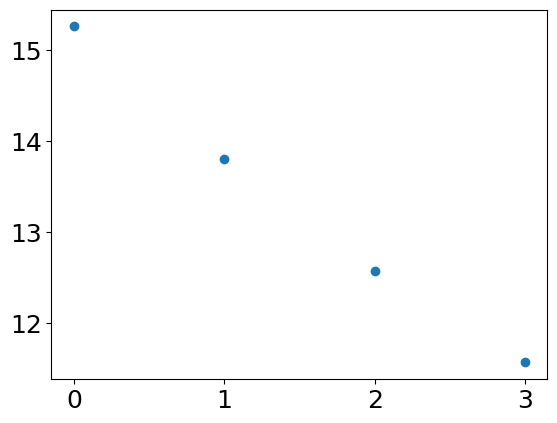

In [29]:
from sklearn.linear_model import LinearRegression
x = np.array([0, 1, 2, 3]).reshape((-1, 1))
y = np.array([15.26, 13.80, 12.58, 11.57])
model = LinearRegression()
model.fit(x, y)
print(model.intercept_, model.coef_)
plt.scatter([0, 1, 2, 3], [15.26, 13.80, 12.58, 11.57])

## Anova

In [30]:
df_parafoveal_anova = pd.melt(df_parafoveal.reset_index(), id_vars=['model_idx'], value_vars=df_parafoveal.columns)
df_parafoveal_anova.columns = ["model_idx", "parafovea", "mean"]
df_parafoveal_anova.head(400)

,model_idx,parafovea,mean
0,0,0 Parafoveal Features,2.325000
1,1,0 Parafoveal Features,2.314375
2,2,0 Parafoveal Features,2.427812
3,3,0 Parafoveal Features,2.426094
4,4,0 Parafoveal Features,2.471875
...,...,...,...
395,125,2 Parafoveal Features,2.268281
396,126,2 Parafoveal Features,2.287656
397,127,2 Parafoveal Features,2.296094
398,128,2 Parafoveal Features,2.254688


In [31]:
res = pg.rm_anova(data=df_parafoveal_anova, dv='mean', within='parafovea', subject='model_idx', 
                  correction=True, detailed=True)
res

/home/wpugsley/.local/lib/python3.11/site-packages/pingouin/distribution.py:1004: RuntimeWarning: divide by zero encountered in double_scalars
  W = np.prod(eig) / (eig.sum() / d) ** d


,Source,SS,DF,MS,F,p-unc,p-GG-corr,ng2,eps,sphericity,W-spher,p-spher
0,parafovea,0.587404,3,0.195801,3911.087217,1.041995e-128,2.477531e-77,0.484014,0.592474,True,inf,1.0
1,Error,0.006608,132,0.000050,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Check Assumptions

In [32]:
pg.sphericity(data=df_parafoveal_anova, dv='mean', within='parafovea', subject='model_idx')

/home/wpugsley/.local/lib/python3.11/site-packages/pingouin/distribution.py:1004: RuntimeWarning: divide by zero encountered in double_scalars
  W = np.prod(eig) / (eig.sum() / d) ** d


SpherResults(spher=True, W=inf, chi2=-inf, dof=5, pval=1.0)

In [33]:
pg.normality(data=df_parafoveal_anova, dv='mean', group='parafovea', alpha=0.05)
#pg.normality(data=df_parafoveal_anova, dv='mean', group='parafovea', alpha=0.05/4)

,W,pval,normal
parafovea,,,
0 Parafoveal Features,0.977094,0.506859,True
1 Parafoveal Feature,0.989289,0.384624,True
2 Parafoveal Features,0.979696,0.041346,False
3 Parafoveal Features,0.965063,0.190115,True


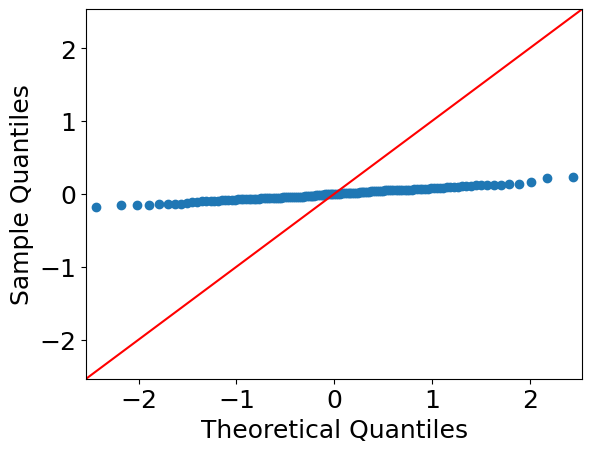

In [34]:
sm.qqplot(df_parafoveal["1 Parafoveal Feature"]-df_parafoveal["1 Parafoveal Feature"].mean(), line='45')
plt.show()

## Pairwise t-Tests

In [35]:
post_hocs = pg.pairwise_tests(data=df_parafoveal_anova, dv='mean', within='parafovea', subject='model_idx', 
                              padjust='bonf', alternative='two-sided')
post_hocs[post_hocs.B=="3 Parafoveal Features"]
post_hocs

,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,hedges
0,parafovea,0 Parafoveal Features,1 Parafoveal Feature,True,True,68.647296,44.0,two-sided,2.164751e-46,1.298851e-45,bonf,4.72e+42,1.889993
1,parafovea,0 Parafoveal Features,2 Parafoveal Features,True,True,80.164746,44.0,two-sided,2.481175e-49,1.488705e-48,bonf,3.522e+45,1.979671
2,parafovea,0 Parafoveal Features,3 Parafoveal Features,True,True,68.842210,44.0,two-sided,1.913008e-46,1.147805e-45,bonf,5.326e+42,2.354840
3,parafovea,1 Parafoveal Feature,2 Parafoveal Features,True,True,8.294551,44.0,two-sided,1.529155e-10,9.174928e-10,bonf,6.762e+07,0.127697
4,parafovea,1 Parafoveal Feature,3 Parafoveal Features,True,True,24.173693,44.0,two-sided,4.875958e-27,2.925575e-26,bonf,6.138e+23,0.522152
5,parafovea,2 Parafoveal Features,3 Parafoveal Features,True,True,21.020380,44.0,two-sided,1.413218e-24,8.479307e-24,bonf,2.461e+21,0.386700


In [36]:
print(f"Treatment A & Treatment B & $p$-value & DOF & $T$\\\\")
print("\\hline")
for row in post_hocs.iterrows():
    row = row[1]
    print(f"{row['A']} & {row['B']} & ${row['p-corr']}$ & ${int(row['dof'])}$ & ${row['T']:.2f}$\\\\")

Treatment A & Treatment B & $p$-value & DOF & $T$\\
\hline
0 Parafoveal Features & 1 Parafoveal Feature & $1.298850884223792e-45$ & $44$ & $68.65$\\
0 Parafoveal Features & 2 Parafoveal Features & $1.4887047511321192e-48$ & $44$ & $80.16$\\
0 Parafoveal Features & 3 Parafoveal Features & $1.1478047058685367e-45$ & $44$ & $68.84$\\
1 Parafoveal Feature & 2 Parafoveal Features & $9.174927670558722e-10$ & $44$ & $8.29$\\
1 Parafoveal Feature & 3 Parafoveal Features & $2.9255745321654874e-26$ & $44$ & $24.17$\\
2 Parafoveal Features & 3 Parafoveal Features & $8.479307092514541e-24$ & $44$ & $21.02$\\


## Pairwise ANOVA

In [37]:
results = pairwise_anova(df_parafoveal_anova, ['0 Parafoveal Features', '1 Parafoveal Features',
                         '2 Parafoveal Features', '3 Parafoveal Features'], 
                         dv='mean', within='parafovea', subject='model_idx', 
                         correction=True, detailed=True)

/home/wpugsley/.local/lib/python3.11/site-packages/pingouin/parametric.py:569: RuntimeWarning: divide by zero encountered in double_scalars
  ms_with = ss_with / ddof1
/home/wpugsley/.local/lib/python3.11/site-packages/pingouin/parametric.py:570: RuntimeWarning: invalid value encountered in double_scalars
  ms_reswith = ss_reswith / ddof2
/home/wpugsley/.local/lib/python3.11/site-packages/pingouin/parametric.py:569: RuntimeWarning: divide by zero encountered in double_scalars
  ms_with = ss_with / ddof1
/home/wpugsley/.local/lib/python3.11/site-packages/pingouin/parametric.py:570: RuntimeWarning: invalid value encountered in double_scalars
  ms_reswith = ss_reswith / ddof2
/home/wpugsley/.local/lib/python3.11/site-packages/pingouin/parametric.py:569: RuntimeWarning: divide by zero encountered in double_scalars
  ms_with = ss_with / ddof1
/home/wpugsley/.local/lib/python3.11/site-packages/pingouin/parametric.py:570: RuntimeWarning: invalid value encountered in double_scalars
  ms_reswit

In [31]:
for result in results:
    print(f"{result[0]} and {result[1]} gives")
    try:
        print("\t", result[2]["p-GG-corr"][0])
    except:
        print("\t", result[2]["p-unc"][0])

0 Parafoveal Features and 1 Parafoveal Features gives
	 2.7801855065988087e-35
0 Parafoveal Features and 2 Parafoveal Features gives
	 1.2308130088991985e-36
0 Parafoveal Features and 3 Parafoveal Features gives
	 8.080354742292325e-38
1 Parafoveal Features and 2 Parafoveal Features gives
	 2.0994755414423397e-38
1 Parafoveal Features and 3 Parafoveal Features gives
	 1.0590322258848192e-39
2 Parafoveal Features and 3 Parafoveal Features gives
	 2.1208538143108464e-41
